In [1]:
import os
import numpy as np
import torch
import pyedflib
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn as nn
import torch.nn.functional as F

# 고정 설정
sampling_rate = 256
segment_length = 30 * sampling_rate
label_map = {
    'Sleep stage W': 0,
    'Sleep stage N1': 1,
    'Sleep stage N2': 2,
    'Sleep stage N3': 3,
    'Sleep stage R': 4
}
root_dir = "/home/mhb0917/캡스톤디자인/sleep/recordings"


In [2]:
def load_data_from_sn(sn_list):
    all_segments = []
    all_labels = []

    for sn in sn_list:
        base = f"SN{sn:03d}"
        ecg_path = os.path.join(root_dir, f"{base}.edf")
        label_path = os.path.join(root_dir, f"{base}_sleepscoring.edf")

        if not os.path.exists(ecg_path) or not os.path.exists(label_path):
            print(f"❌ 파일 없음: {base}")
            continue

        try:
            ecg_reader = pyedflib.EdfReader(ecg_path)
            ecg_signal = ecg_reader.readSignal(7)
        finally:
            ecg_reader._close()

        try:
            label_reader = pyedflib.EdfReader(label_path)
            annotations = label_reader.readAnnotations()
        finally:
            label_reader._close()

        onsets, durations, labels = annotations
        label_seq = []
        for i in range(len(labels)):
            label_str = labels[i].decode() if isinstance(labels[i], bytes) else labels[i]
            if label_str in label_map:
                label_index = label_map[label_str]
                num_segments = int(durations[i] // 30)
                label_seq.extend([label_index] * num_segments)

        # ⚠️ 반드시 가능한 segment 수 계산 후 최소로 맞춤
        max_possible_segments = len(ecg_signal) // segment_length
        num_segments = min(len(label_seq), max_possible_segments)

        ecg_segments = []
        for i in range(num_segments):
            start = i * segment_length
            end = start + segment_length
            segment = ecg_signal[start:end]
            segment = (segment - np.mean(segment)) / (np.std(segment) + 1e-8)
            ecg_segments.append(segment)

        all_segments.extend(ecg_segments)
        all_labels.extend(label_seq[:num_segments])

    # 텐서 변환
    X = torch.tensor(np.array(all_segments), dtype=torch.float32).unsqueeze(1)
    y = torch.tensor(all_labels, dtype=torch.long)
    return X, y


In [3]:
# SN001 ~ SN140 → 학습용
X_train, y_train = load_data_from_sn(list(range(1, 141)))

# SN141 ~ SN151 → 테스트용
X_test, y_test = load_data_from_sn(list(range(141, 154)))

print("✅ 학습 데이터:", X_train.shape, y_train.shape)
print("✅ 테스트 데이터:", X_test.shape, y_test.shape)


❌ 파일 없음: SN014
❌ 파일 없음: SN064
❌ 파일 없음: SN135
✅ 학습 데이터: torch.Size([124758, 1, 7680]) torch.Size([124758])
✅ 테스트 데이터: torch.Size([11482, 1, 7680]) torch.Size([11482])


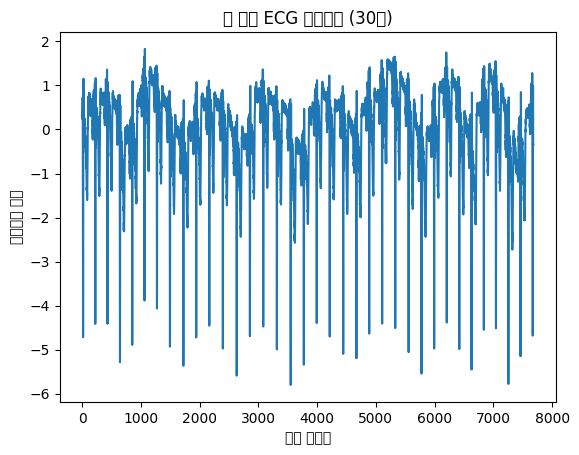

In [29]:
import matplotlib.pyplot as plt

plt.plot(X_train[12000][0][:].numpy())  # 첫 번째 세그먼트의 ECG 시계열
plt.title("첫 번째 ECG 세그먼트 (30초)")
plt.xlabel("샘플 인덱스")
plt.ylabel("정규화된 전압")
plt.show()

In [30]:
print("🧪 X_train shape:", X_train.shape)
print("🧪 y_train shape:", y_train.shape)


🧪 X_train shape: torch.Size([124758, 1, 7680])
🧪 y_train shape: torch.Size([124758])


In [31]:
class ECGSleepCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(ECGSleepCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * 960, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [32]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGSleepCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 학습 루프
for epoch in range(5):
    model.train()
    loss_sum, correct, total = 0.0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        loss = criterion(outputs, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, pred = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (pred == yb).sum().item()

    acc = 100 * correct / total
    print(f"📘 Epoch {epoch+1} | Loss: {loss_sum:.4f} | Acc: {acc:.2f}%")


📘 Epoch 1 | Loss: 6025.1273 | Acc: 36.08%
📘 Epoch 2 | Loss: 5951.7494 | Acc: 36.40%
📘 Epoch 3 | Loss: 5948.8260 | Acc: 36.41%
📘 Epoch 4 | Loss: 5949.5386 | Acc: 36.40%
📘 Epoch 5 | Loss: 5949.6022 | Acc: 36.40%


In [33]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for i in range(0, len(X_test), 32):
        xb = X_test[i:i+32].to(device)
        yb = y_test[i:i+32].to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())


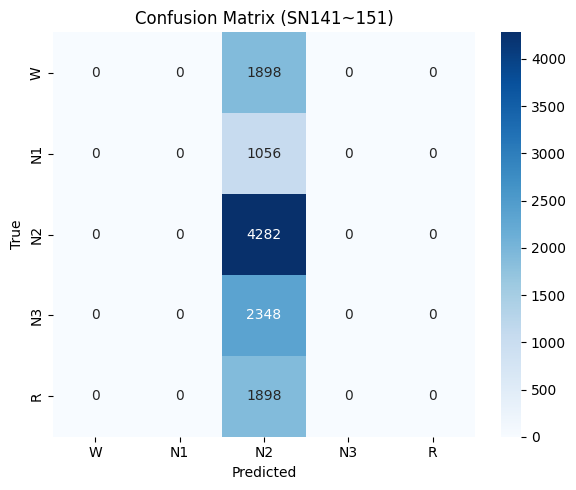

📄 Classification Report:
              precision    recall  f1-score   support

           W       0.00      0.00      0.00      1898
          N1       0.00      0.00      0.00      1056
          N2       0.37      1.00      0.54      4282
          N3       0.00      0.00      0.00      2348
           R       0.00      0.00      0.00      1898

    accuracy                           0.37     11482
   macro avg       0.07      0.20      0.11     11482
weighted avg       0.14      0.37      0.20     11482



/home/mhb0917/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mhb0917/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mhb0917/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
labels = ['W', 'N1', 'N2', 'N3', 'R']

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (SN141~151)")
plt.tight_layout()
plt.show()

# Classification Report
print("📄 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=labels))
